<a href="https://colab.research.google.com/github/5655530/AIFFEL_CORE_QUEST/blob/main/MainQuest04/MainQuest04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사용할 버전 확인

## STEP 0. 설계
---

메인 퀘스트에 참가하여 유의미한 점수를 거두기 위하여 아래와 같은 과정으로 프로젝트를 진행하여 본다.

1. 데이터 살펴보기
    - 이번 프로젝트의 목표는 주어진 데이터를 모델에 학습시켜, 입력이 주어졌을 때 가위 바위 보를 분류해 내는 것이다.
    - 데이터를 읽어들여 온다.
2. 데이터 전처리
    - 주어진 데이터를 학습하기에 알맞은 크기의 사이즈로 reshape한다.
    - 가공한 데이터를 정답에 맞게 가위, 바위, 보로 라벨링 한다.
3. 모델링과 하이퍼 파라미터 튜닝
    - KerasClassifier를 이용하여 Keras 모델을 Scikit-learn의 분류기 인터페이스로 감싸서 사용할 수 있게 한다.
    - 랜덤 서치를 이용하여 모델에 대한 하이퍼 파라미터 튜닝을 진행한다.
4. 제출
    - LMS에 모델을 제출하고 결과를 확인한다.


In [21]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
print(tf.__version__)
print(np.__version__)

2.12.0
1.22.4


# 데이터 불러오기 + Resize 하기
* PIL 라이브러리 불러오기

In [4]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


* 파일 압축 풀기

In [29]:
%cd /content/drive/MyDrive/aiffel/rock_scissor_paper/
!unzip -qq "/content/drive/MyDrive/aiffel/rock_scissor_paper/train.zip"

/content/drive/MyDrive/aiffel/rock_scissor_paper


* 이미지 파일 리사이즈 (64, 64)

In [45]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")
	images_png=glob.glob(img_path + "/*.png")

	print(len(images), " images to be resized.")

    # 파일마다 모두 64x64 사이즈로 바꾸어 저장합니다.
	target_size=(64,64)
	for img in images:
		old_img=Image.open(img).convert("RGB")
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")

	for img in images_png:
		old_img=Image.open(img).convert("RGB")
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "PNG")

	print(len(images), " images resized.")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path =  "/content/drive/MyDrive/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/rock_scissor_paper/paper"

# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path =  "/content/drive/MyDrive/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

638  images to be resized.


<ipython-input-45-2ac1b5664aa6>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)
<ipython-input-45-2ac1b5664aa6>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


638  images resized.
바위 이미지 resize 완료!
497  images to be resized.
497  images resized.
보 이미지 resize 완료!
941  images to be resized.
941  images resized.
가위 이미지 resize 완료!


* 가위: 0, 바위: 1, 보: 2 의 형태로 데이터 라벨링 후 훈련 데이터 셋 생성

In [47]:
import numpy as np

def load_data(img_path, number_of_data=4599):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=64
    color=3
    imgs=np.zeros(number_of_data*img_size*img_size*color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels=np.zeros(number_of_data, dtype=np.int32)

    idx=0
    # 가위 이미지 불러오기
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    for file in glob.iglob(img_path+'/scissor/*.png'):
        img = np.array(Image.open(file).convert("RGB"), dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    # 바위 이미지 불러오기
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file).convert("RGB"), dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1

    # 보 이미지 불러오기
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file).convert("RGB"), dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/drive/MyDrive/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 4596 입니다.
x_train shape: (4599, 64, 64, 3)
y_train shape: (4599,)


* 이미지 확인

라벨:  0


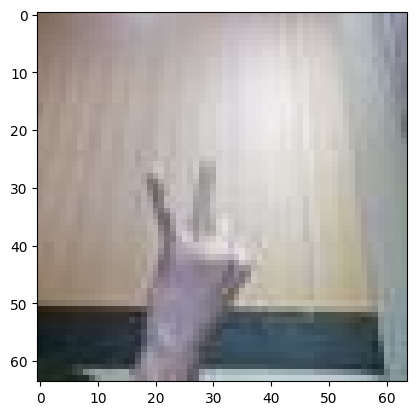

In [48]:
from matplotlib import pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

* 모델 생성
  - 4개의 합성곱 층으로 이루어진 모델
  - 오버피팅을 줄이기 위해 dense레이어에서 드롭아웃 실행

In [92]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_channel_3=32
n_channel_4=64
n_dense=512
n_train_epoch=10

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(64, 64, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_635 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_635 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_636 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_636 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_637 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_637 (MaxPooli  (None, 8, 8, 32)      

In [89]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train, epochs=n_train_epoch)

model.summary()

Epoch 1/10
144/144 [==============================] - 4s 7ms/step - loss: 1.6413 - accuracy: 0.4597
Epoch 2/10
144/144 [==============================] - 1s 7ms/step - loss: 0.5900 - accuracy: 0.7260
Epoch 3/10
144/144 [==============================] - 1s 7ms/step - loss: 0.4045 - accuracy: 0.8274
Epoch 4/10
144/144 [==============================] - 1s 7ms/step - loss: 0.2790 - accuracy: 0.8848
Epoch 5/10
144/144 [==============================] - 1s 7ms/step - loss: 0.2075 - accuracy: 0.9185
Epoch 6/10
144/144 [==============================] - 1s 7ms/step - loss: 0.1624 - accuracy: 0.9350
Epoch 7/10
144/144 [==============================] - 1s 7ms/step - loss: 0.1427 - accuracy: 0.9428
Epoch 8/10
144/144 [==============================] - 1s 8ms/step - loss: 0.1136 - accuracy: 0.9550
Epoch 9/10
144/144 [==============================] - 1s 10ms/step - loss: 0.1506 - accuracy: 0.9482
Epoch 10/10
144/144 [==============================] - 1s 10ms/step - loss: 0.1021 - accuracy: 0.96

In [16]:
%cd /content/drive/MyDrive/aiffel/rock_scissor_paper/rock_test
!unzip -qq "/content/drive/MyDrive/aiffel/rock_scissor_paper/Rock_test.zip"

/content/drive/MyDrive/aiffel/rock_scissor_paper/rock_test
replace 0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
%cd /content/drive/MyDrive/aiffel/rock_scissor_paper/paper_test
!unzip -qq "/content/drive/MyDrive/aiffel/rock_scissor_paper/Paper_test.zip"

/content/drive/MyDrive/aiffel/rock_scissor_paper/paper_test
replace 0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [18]:
%cd /content/drive/MyDrive/aiffel/rock_scissor_paper/scissor_test
!unzip -qq "/content/drive/MyDrive/aiffel/rock_scissor_paper/Scissor_test.zip"

/content/drive/MyDrive/aiffel/rock_scissor_paper/scissor_test
replace 0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

* x_test, y_test 데이터 생성

In [90]:
# x_test, y_test를 만드는 방법은 x_train, y_train을 만드는 방법과 아주 유사합니다.

def resize_images(img_path):
	images=glob.glob(img_path + "/*.png")

	print(len(images), " images to be resized.")

    # 파일마다 모두 64x64 사이즈로 바꾸어 저장합니다.
	target_size=(64,64)
	for img in images:
		old_img=Image.open(img).convert("RGB")
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "PNG")

	print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

image_dir_path = "/content/drive/MyDrive/aiffel/rock_scissor_paper/test/scissors"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

image_dir_path = "/content/drive/MyDrive/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

def load_data(img_path, number_of_data=372):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=64
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("테스트 데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path =  "/content/drive/MyDrive/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

124  images to be resized.


<ipython-input-90-ed8aebda7bb8>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


124  images resized.
바위 이미지 resize 완료!
124  images to be resized.
124  images resized.
가위 이미지 resize 완료!
124  images to be resized.
124  images resized.
보 이미지 resize 완료!
테스트 데이터(x_test)의 이미지 개수는 248 입니다.
x_test shape: (372, 64, 64, 3)
y_test shape: (372,)


* 검증 데이터를 이용해 모델 검증, 정확도가 92퍼센트정도로 나오는 것을 볼수있다.

In [91]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

12/12 - 0s - loss: 0.4643 - accuracy: 0.9220 - 226ms/epoch - 19ms/step
test_loss: 0.4643009901046753 
test_accuracy: 0.9220430254936218
